## Part I: Build a classification model to predict spend range for tech companies

### Table of Contents

1.[Summary](#summary)\
2.[Import Libraries and Data](#import)\
3.[Data Exploration](#data)\
4.[Data Transformation](#processing)\
5.[Build the Base Model](#base)\
6.[Tune the Model with Pipelines, GridSearch and PCA](#tune)\
7.[Visualize the Results](#visual)

### 1. Summary

In this notebook, I am trying to predict the national advertising spend ranges of top 30 tech companies based on how much they spent in 2018 and 2019 using different classification algorithm.

When building the model, I first create train and test sets and build a base decision tree model. Then I incorporated PCA and built pipelines with other classification methods such as RandomForest, XGBoost, SVM and find out the best performed model. 

### 2. Import Libraries and Data
<a name='import'></a>

In [105]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA

In [49]:
comp = pd.read_csv("competitive_master.csv")

In [50]:
comp.describe()

,Unnamed: 0,Rank,Revenue_Billion,Financial Year,Employees,Market cap_Billion,Founded,DMA_Code,IsTop31,Total Persons 12+,Month,Spend_K,Year
count,2.159350e+05,215935.000000,215935.000000,215935.000000,215935.000000,212657.000000,215935.000000,215935.000000,215935.000000,2.159350e+05,215935.000000,215935.000000,215935.000000
mean,5.492127e+05,9.805923,114.270432,2017.988617,247026.083641,533.907453,1997.172256,590.466909,0.317308,1.812687e+07,6.893510,44.377307,2018.472230
std,2.986108e+05,12.567042,108.225244,0.106083,290389.640669,415.688519,6.668268,177.225032,0.465430,6.331413e+07,3.438027,708.473195,0.499229
min,0.000000e+00,1.000000,1.050000,2017.000000,1700.000000,0.300000,1981.000000,0.000000,0.000000,8.100000e+03,1.000000,0.000000,2018.000000
25%,3.040425e+05,1.000000,10.500000,2018.000000,20000.000000,100.400000,1994.000000,524.000000,0.000000,8.832000e+05,4.000000,0.000000,2018.000000
50%,5.497940e+05,2.000000,120.800000,2018.000000,103549.000000,791.010000,1998.000000,577.000000,0.000000,1.991600e+06,7.000000,0.000000,2018.000000
75%,8.135210e+05,15.000000,253.900000,2018.000000,647500.000000,972.340000,1999.000000,679.000000,1.000000,4.226900e+06,10.000000,0.300000,2019.000000
max,1.037422e+06,53.000000,253.900000,2018.000000,647500.000000,972.340000,2011.000000,881.000000,1.000000,2.816179e+08,12.000000,91324.500000,2019.000000


In [51]:
comp.columns

Index(['Unnamed: 0', 'INDUSTRY', 'PARENT', 'ADVERTISER', 'BRAND', 'MARKET',
       'MEDIA', 'Company', 'Rank', 'Revenue_Billion', 'Financial Year',
       'Employees', 'Market cap_Billion', 'Founded', 'DMA_Code', 'NIELSEN DMA',
       'Region_Name', 'Division_Name', 'IsTop31', ' Total Persons 12+ ',
       'Month', 'Spend_K', 'Year'],
      dtype='object')

In [52]:
comp=comp.drop('Unnamed: 0', axis=1)

In [53]:
comp=comp.rename(columns={" Total Persons 12+ ":"Audience Population"})

### 3. Data Exploration
<a name='data'></a>

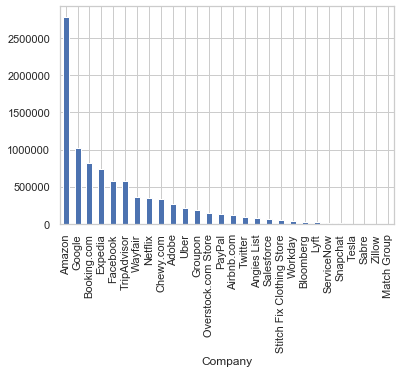

In [54]:
#Competitor's National Advertising Spend Rank

comp[comp['DMA_Code']==0].groupby(['Company'])['Spend_K'].sum().sort_values(ascending=False).plot.bar()

In [55]:
national_spend = comp[(comp['DMA_Code']==0) & (comp['Year']==2018)].groupby(['Company'])['Spend_K'].sum()
avg_revenue = comp[comp['Year']==2018].groupby(['Company'])['Revenue_Billion'].mean()
nat_spend_revenue_ratio = national_spend/avg_revenue/1000000

In [56]:
nat_spend_revenue_ratio.head()

Company
Adobe          0.013870
Airbnb.com     0.020704
Amazon         0.004741
Angies List    0.029709
Bloomberg      0.001041
dtype: float64

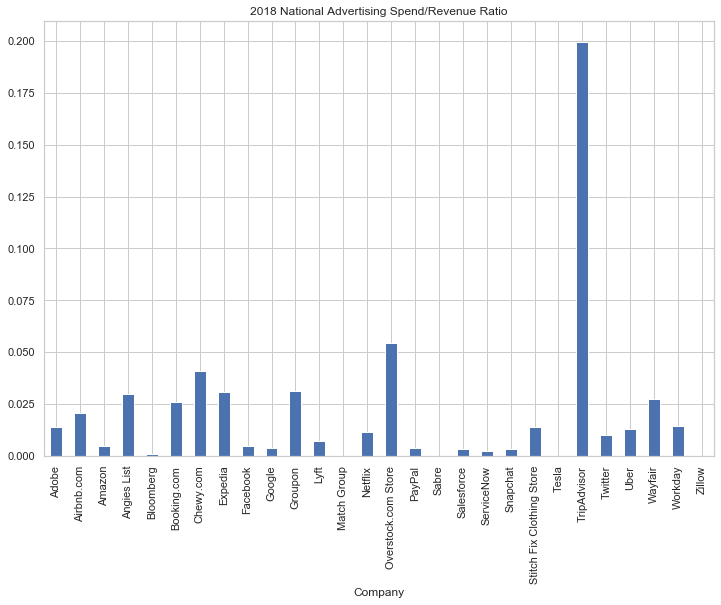

In [57]:
nat_spend_revenue_ratio.plot.bar(figsize=(12,8),title='2018 National Advertising Spend/Revenue Ratio')

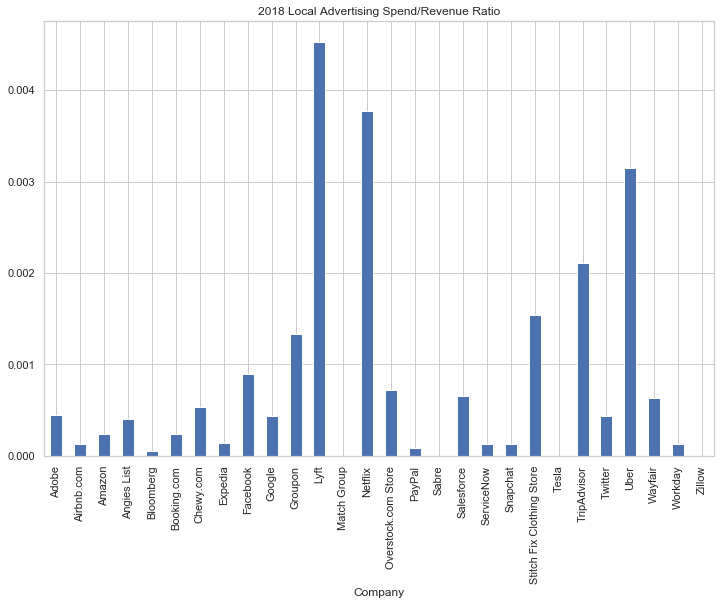

In [58]:
local_spend = comp[(comp['DMA_Code']!=0) & (comp['Year']==2018)].groupby(['Company'])['Spend_K'].sum()
avg_revenue = comp[comp['Year']==2018].groupby(['Company'])['Revenue_Billion'].mean()
local_spend_revenue_ratio = local_spend/avg_revenue/1000000
local_spend_revenue_ratio.plot.bar(figsize=(12,8),title='2018 Local Advertising Spend/Revenue Ratio')

Insight: TripAdvisor spent largest % of their revenue in National advertising, while Lyft, Uber and Netflix spent more in local markets because their marketing efforts are more market-diven

Text(0.5, 1.0, 'Annual Revenue')

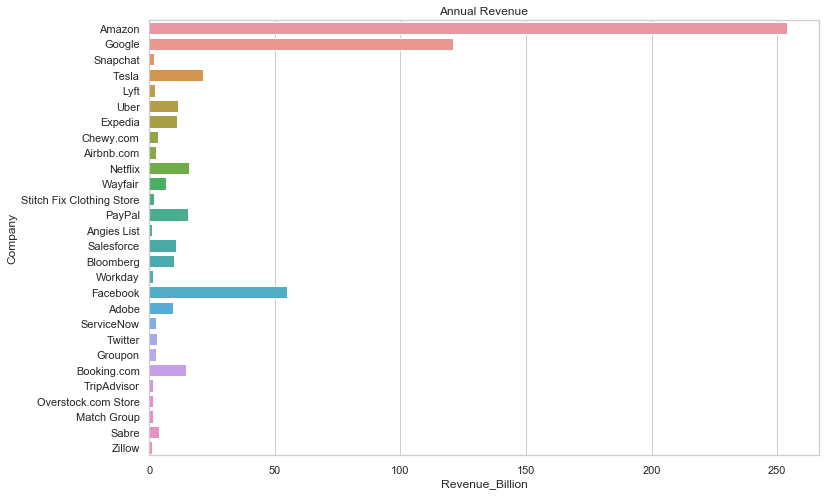

In [59]:
plt.figure(figsize=(12,8))
sns.set(style='whitegrid')
ax = sns.barplot(y='Company', x='Revenue_Billion', data=comp)
plt.title('Annual Revenue')

Add more charts on Media Mix, Market Distribution later

### 4. Data Processing and Transformation
<a name='processing'></a>

In [60]:
comp.describe()

,Rank,Revenue_Billion,Financial Year,Employees,Market cap_Billion,Founded,DMA_Code,IsTop31,Audience Population,Month,Spend_K,Year
count,215935.000000,215935.000000,215935.000000,215935.000000,212657.000000,215935.000000,215935.000000,215935.000000,2.159350e+05,215935.000000,215935.000000,215935.000000
mean,9.805923,114.270432,2017.988617,247026.083641,533.907453,1997.172256,590.466909,0.317308,1.812687e+07,6.893510,44.377307,2018.472230
std,12.567042,108.225244,0.106083,290389.640669,415.688519,6.668268,177.225032,0.465430,6.331413e+07,3.438027,708.473195,0.499229
min,1.000000,1.050000,2017.000000,1700.000000,0.300000,1981.000000,0.000000,0.000000,8.100000e+03,1.000000,0.000000,2018.000000
25%,1.000000,10.500000,2018.000000,20000.000000,100.400000,1994.000000,524.000000,0.000000,8.832000e+05,4.000000,0.000000,2018.000000
50%,2.000000,120.800000,2018.000000,103549.000000,791.010000,1998.000000,577.000000,0.000000,1.991600e+06,7.000000,0.000000,2018.000000
75%,15.000000,253.900000,2018.000000,647500.000000,972.340000,1999.000000,679.000000,1.000000,4.226900e+06,10.000000,0.300000,2019.000000
max,53.000000,253.900000,2018.000000,647500.000000,972.340000,2011.000000,881.000000,1.000000,2.816179e+08,12.000000,91324.500000,2019.000000


In [61]:
comp.columns

Index(['INDUSTRY', 'PARENT', 'ADVERTISER', 'BRAND', 'MARKET', 'MEDIA',
       'Company', 'Rank', 'Revenue_Billion', 'Financial Year', 'Employees',
       'Market cap_Billion', 'Founded', 'DMA_Code', 'NIELSEN DMA',
       'Region_Name', 'Division_Name', 'IsTop31', 'Audience Population',
       'Month', 'Spend_K', 'Year'],
      dtype='object')

In [62]:
#Remove Industry, Parent, Advertiser, Brand, Nielsen DMA, Region Name

comp_df = pd.pivot_table(comp, values=['BRAND','Rank','Revenue_Billion','Employees','Market cap_Billion','Founded','IsTop31','Audience Population','Spend_K'],
                        index = ['Company','DMA_Code','MEDIA','Division_Name','Year','Month'],
                        aggfunc={'BRAND':'count', 'Rank':np.mean, 'Revenue_Billion':np.mean, 'Employees':np.mean, 'Market cap_Billion':np.mean, 'Founded':np.mean,'Audience Population': np.mean,'Spend_K':np.sum, 'IsTop31': np.mean })

In [63]:
comp_df = comp_df.reset_index()

There is a huge gap between National Spend and Local Spend. To get more accurate and reasonable mode, we separate National and Local. 

In [64]:
#turn DMA_Code, IsTop31 to Categorical values
comp_df['DMA_Code'] = comp_df['DMA_Code'].astype('category')
comp_df['IsTop31'] = comp_df['IsTop31'].astype('category')

In [65]:
#duplicate Rank as Company ID 
comp_df['Company_ID']=comp_df['Rank'].astype('category')

In [66]:
#Create dummies for MEDIA and Division
media = pd.get_dummies(comp_df['MEDIA'], prefix='Media')
division = pd.get_dummies(comp_df['Division_Name'], prefix='Div')

In [67]:
comp_df_new = pd.concat([comp_df, media, division],axis=1)

In [68]:
comp_df_new.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
0,Adobe,0,B-to-B,National,2018,1,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
1,Adobe,0,B-to-B,National,2018,4,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
2,Adobe,0,B-to-B,National,2018,8,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
3,Adobe,0,B-to-B,National,2018,9,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
4,Adobe,0,B-to-B,National,2018,10,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0


### National Spend data set

In [69]:
nat_comp_df = comp_df_new[comp_df_new['DMA_Code']==0]
nat_comp_df.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
0,Adobe,0,B-to-B,National,2018,1,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
1,Adobe,0,B-to-B,National,2018,4,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
2,Adobe,0,B-to-B,National,2018,8,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
3,Adobe,0,B-to-B,National,2018,9,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
4,Adobe,0,B-to-B,National,2018,10,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0


In [70]:
nat_comp_data = nat_comp_df.drop(columns=['Company','Div_ALL OTHER','Div_Central','Div_National','Div_Northeast','Div_West','Division_Name','MEDIA','DMA_Code'], axis=1)

In [71]:
nat_comp_data.head()

,Year,Month,Audience Population,BRAND,Employees,Founded,IsTop31,Market cap_Billion,Rank,Revenue_Billion,...,Media_Natl Spot Radio,Media_Network Radio,Media_Network TV,Media_Newspapers,Media_Online Video,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication
0,2018,1,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0
1,2018,4,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0
2,2018,8,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0
3,2018,9,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0
4,2018,10,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0


#### Create Bins for Spend_K

In [72]:
nat_comp_data.Spend_K.quantile(list(np.linspace(0,1,11)))

0.0        0.00
0.1        6.10
0.2       29.48
0.3       86.60
0.4      192.34
0.5      399.95
0.6      737.60
0.7     1376.33
0.8     2490.18
0.9     6015.89
1.0    92615.30
Name: Spend_K, dtype: float64

In [73]:
#80% values are between 0 to 2500
BINS = [0,30,100,500,1000,3000,100000]

In [74]:
nat_comp_data['Spend_Bins'] = pd.cut(x=nat_comp_data.Spend_K, bins=BINS, labels=False)

In [75]:
nat_comp_data['Spend_Bins']

0        2.0
1        0.0
2        2.0
3        2.0
4        3.0
        ... 
95727    0.0
95728    0.0
95729    0.0
95730    0.0
95731    0.0
Name: Spend_Bins, Length: 3578, dtype: float64

In [76]:
nat_comp_data = nat_comp_data.drop('Spend_K', axis=1)

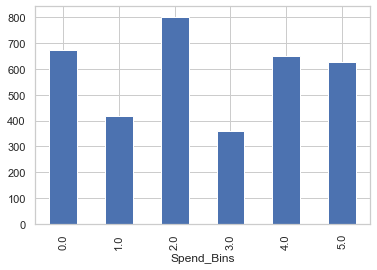

In [77]:
nat_comp_data.groupby('Spend_Bins')['BRAND'].count().plot.bar()

In [83]:
#Remove all NAs
nat_comp_data = nat_comp_data.dropna(how='any')

### Local Market Level Spend Data

In [31]:
local_df = comp_df_new[comp_df_new['DMA_Code']!=0]
local_df.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
118,Adobe,500,Int Display,Northeast,2018,1,892300,5,21200,1982,...,0,0,0,0,0,0,0,0,1,0
119,Adobe,500,Int Display,Northeast,2018,2,892300,6,21200,1982,...,0,0,0,0,0,0,0,0,1,0
120,Adobe,500,Int Display,Northeast,2018,3,892300,6,21200,1982,...,0,0,0,0,0,0,0,0,1,0
121,Adobe,500,Int Display,Northeast,2018,4,892300,6,21200,1982,...,0,0,0,0,0,0,0,0,1,0
122,Adobe,500,Int Display,Northeast,2018,5,892300,5,21200,1982,...,0,0,0,0,0,0,0,0,1,0


In [32]:
local_df.Spend_K.quantile(list(np.linspace(0,1,11)))

0.0       0.0
0.1       0.0
0.2       0.0
0.3       0.0
0.4       0.0
0.5       0.1
0.6       0.2
0.7       0.5
0.8       1.4
0.9       6.0
1.0    2390.1
Name: Spend_K, dtype: float64

Local Spend looks very umbalanced and minimal compared to National Spend. We will focus on National Spend first. d

### 5. Build the base Model
<a namek='base'></a>

### Train and Test Split

In [84]:
#Split the data into training and test sets
y = nat_comp_data['Spend_Bins']
X = nat_comp_data.drop('Spend_Bins', axis=1)

In [85]:
y

0        2.0
1        0.0
2        2.0
3        2.0
4        3.0
        ... 
95727    0.0
95728    0.0
95729    0.0
95730    0.0
95731    0.0
Name: Spend_Bins, Length: 3306, dtype: float64

### Standaridize the data set

In [86]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
scaled_features = pd.DataFrame(scaled, columns=X.columns)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.25, random_state=4)

### Use Decision Tree to Build the Base Model

In [88]:
#Instantiate and fit a Decision Tree
dt = DecisionTreeClassifier(random_state=4)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=4, splitter='best')

In [89]:
dt.score(X_train, y_train)

1.0

In [90]:
dt.score(X_test, y_test)

0.5308343409915357

In [92]:
cross_val_score(dt, X_test, y_test, cv=5)

array([0.45238095, 0.4491018 , 0.47878788, 0.48780488, 0.47852761])

The mean accuracy on the test set is much lower than the training set. Let's try testing out different hyperparameters!

### 6. Tune the model with Grid Search and Pipelines

In [98]:
dt_grid = {
    
    'criterion':['gini','entropy'],
    'max_depth':[None, 5,8,10],
    'min_samples_split':[2,5,10,20],
    'max_features':['auto','sqrt','log2',None]
      
}

In [99]:
dt_grid_search = GridSearchCV(dt, dt_grid, cv=3, return_train_score = True, n_jobs=1)
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=4,
                                              splitter='best'),
             iid='warn', n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 8, 10],
                         'm

In [100]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print("Mean Training Score: ", dt_gs_training_score)
print("Mean Test Score: " , dt_gs_testing_score)
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_estimator_
dt_grid_search.best_params_

Mean Training Score:  0.5598676861714758
Mean Test Score:  0.5308343409915357
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_split': 2}

The training score is no better than the baseline.

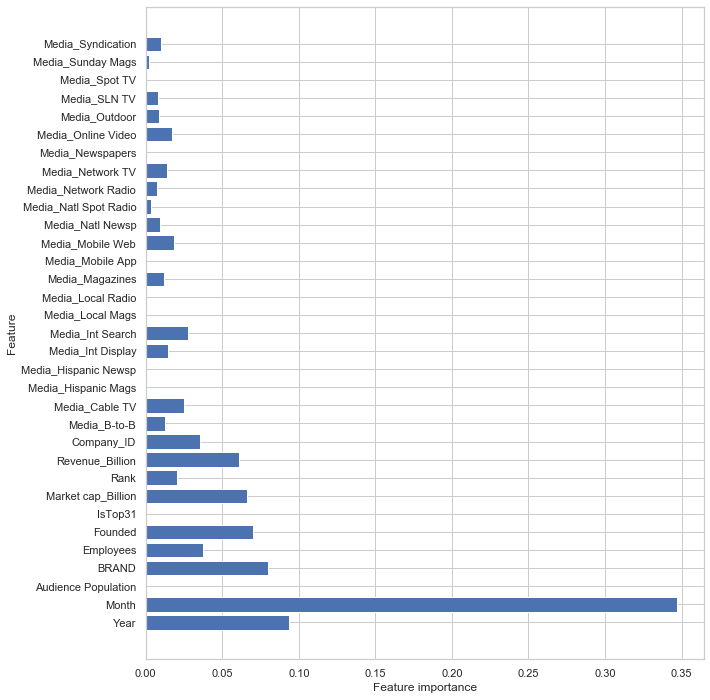

In [101]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


plot_feature_importances(dt)

Year and Month, Number of Brands play a big role in determining the spend

### 6. Create RandomForest, Adaboost and SVM Pipelines with Grid Search
<a name='tune'></a>

### Random Forest pipeline

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [108]:
#Create the pipeline and include PCA in the process

pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=4))])

# Create the grid parameter
param_grid_rf = [
    {'clf__n_estimators':[5,10,15,20,25,30],
    'clf__criterion':['gini','entropy'],
    'clf__max_depth':[None,5,8,10,13],
    'clf__min_samples_split':[2,5,10,20]
    }
]

# Create the grid, with "pipe" as the estimator
gs_rf = GridSearchCV(estimator=pipe_rf,
                  param_grid=param_grid_rf,
                  scoring='accuracy',
                  cv=3, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)


# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Best accuracy: 0.577

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 30}


In [110]:
gs_rf.cv_results_

{'mean_fit_time': array([0.01910917, 0.03092798, 0.04022296, 0.05835311, 0.06820925,
        0.08577434, 0.0166227 , 0.02726086, 0.04373002, 0.06167118,
        0.05286201, 0.07379174, 0.01395973, 0.02393484, 0.03324517,
        0.04156574, 0.05782509, 0.05586108, 0.01064865, 0.01961478,
        0.03341373, 0.04122504, 0.04454446, 0.05118656, 0.00997432,
        0.01928226, 0.02160835, 0.02859036, 0.03324453, 0.04156526,
        0.00931056, 0.01529018, 0.02393484, 0.03324699, 0.03223586,
        0.04155803, 0.00897686, 0.01461705, 0.02659631, 0.03257918,
        0.03690139, 0.04222043, 0.00930929, 0.01761937, 0.0219516 ,
        0.02908516, 0.03490615, 0.04322124, 0.01130287, 0.02094706,
        0.02492309, 0.03523874, 0.04555782, 0.04820863, 0.00997329,
        0.01961422, 0.02892208, 0.03392037, 0.04121272, 0.0492034 ,
        0.01063792, 0.02027829, 0.0289127 , 0.03889831, 0.0375673 ,
        0.04788264, 0.00930882, 0.0179313 , 0.02527634, 0.03344536,
        0.0458769 , 0.05052193,

### Adaboost

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [109]:
from sklearn.ensemble import AdaBoostClassifier

# ⏰ This cell may take several minutes to run
from sklearn.ensemble import AdaBoostClassifier
# Construct pipeline
pipe_ab = Pipeline([('clf', AdaBoostClassifier(random_state = 4))])

# Set grid search params
adaboost_param_grid = {
    'clf__n_estimators': [10, 20, 30],
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

# Construct grid search
gs_ab = GridSearchCV(estimator=pipe_ab,
            param_grid=adaboost_param_grid,
            scoring='accuracy',
            cv=3, return_train_score = True)

# Fit using grid search
gs_ab.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_ab.best_score_)

# Best params
print('\nBest params:\n', gs_ab.best_params_)

Best accuracy: 0.401

Best params:
 {'clf__learning_rate': 0.5, 'clf__n_estimators': 30}


In [112]:
gs_ab.cv_results_

{'mean_fit_time': array([0.0280865 , 0.04487952, 0.06816181, 0.02394589, 0.04553215,
        0.06948113, 0.02325837, 0.04887907, 0.07032768]),
 'std_fit_time': array([3.07213336e-03, 2.97360213e-07, 4.63729155e-04, 1.56272825e-05,
        9.28473587e-04, 4.70358991e-04, 4.56592612e-04, 1.62799178e-03,
        7.27679395e-04]),
 'mean_score_time': array([0.00466045, 0.0066487 , 0.00930882, 0.00399041, 0.00698209,
        0.00964077, 0.00398946, 0.00763456, 0.01030572]),
 'std_score_time': array([9.57868301e-04, 4.70302885e-04, 4.71370394e-04, 1.18411894e-06,
        3.37174788e-07, 4.69740686e-04, 5.15042996e-07, 1.68350640e-03,
        4.70134086e-04]),
 'param_clf__learning_rate': masked_array(data=[1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_clf__n_estimators': masked_array(data=[10, 20, 30, 10, 20, 30, 10, 20, 30],
    

### SVM

In [113]:
from sklearn import svm

In [114]:
# Construct pipeline
pipe_svm = Pipeline([
            ('clf', svm.SVC(random_state=4))])

# Set grid search params
param_grid_svm = [
  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
  {'clf__C': [1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf']},
 ]

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] clf__C=0.1, clf__kernel=linear ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__kernel=linear ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__kernel=linear ..................................
[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.2s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.3s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.2s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.2s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .................... clf__C=10, clf__kernel=linear, total=   0.4s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .................... clf__C=10, clf__kernel=linear, total=   0.4s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    9.5s finished


Best accuracy: 0.421

Best params:
 {'clf__C': 1, 'clf__kernel': 'linear'}


In [115]:
# Your code here 
gs_svm.cv_results_

{'mean_fit_time': array([0.17009616, 0.2017924 , 0.33412655, 0.2773176 , 0.27713617,
        0.25817688, 0.25566101]),
 'std_fit_time': array([0.00916995, 0.02377524, 0.04104901, 0.00939758, 0.01136622,
        0.00274418, 0.01530236]),
 'mean_score_time': array([0.05634085, 0.05785354, 0.05052376, 0.07845608, 0.08010674,
        0.0761172 , 0.07380295]),
 'std_score_time': array([0.0012363 , 0.00215577, 0.00233864, 0.00047081, 0.00234475,
        0.0004512 , 0.00215273]),
 'param_clf__C': masked_array(data=[0.1, 1, 10, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__kernel': masked_array(data=['linear', 'linear', 'linear', 'rbf', 'rbf', 'rbf',
                    'rbf'],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__gamma': masked_array(data=[--, --, --, 0.001, 0.01, 0.001, 0.01],
              ma

### Incoporate PCA

PCA plays a key roles in reducing the number of dimensions, preserving the essence of the original data. There is a way to choose n_components - check the explained variance. 

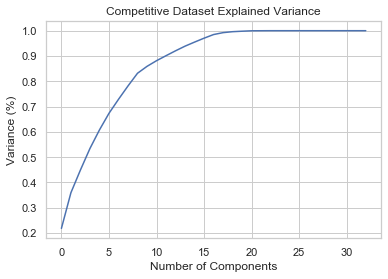

In [116]:
#Fit the PCA with scaled data
pca = PCA().fit(scaled_features)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Competitive Dataset Explained Variance')
plt.show()

This suggests that selecting 15 or 16 components we can preserve around 97% to 99% of the total variance of the data. 

**Check important features after PCA**

In [117]:
np.random.seed(0)

pca = PCA(n_components=15).fit(scaled_features)

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = scaled_features.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [118]:
df

,0,1
0,PC0,Market cap_Billion
1,PC1,Year
2,PC2,Media_Int Display
3,PC3,Media_Mobile Web
4,PC4,Media_Online Video
5,PC5,Media_Cable TV
6,PC6,Month
7,PC7,Company_ID
8,PC8,Media_Network TV
9,PC9,Media_Network TV


In [119]:
pca=PCA(n_components=15)
pca_dataset = pca.fit_transform(scaled_features)

In [120]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(pca_dataset, y, test_size=0.25, random_state=4)

### Pipeline with PCA and Grid Search 

In [121]:
#Create the pipeline and include PCA in the process
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline([
                ('pca', PCA(n_components=15)),
                ('tree', RandomForestClassifier(random_state=4))])

# Create the grid parameter
grid = [{'tree__n_estimators':[5,10,15,20,25,30],
    'tree__criterion':['gini','entropy'],
    'tree__max_depth':[None,5,8,10,13],
    'tree__min_samples_split':[2,5,10,20]}]

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch.fit(X_train_2, y_train_2)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=15, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('tree',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                             

In [123]:
# Best accuracy
print('Best accuracy: %.3f' % gridsearch.best_score_)

# Best params
print('\nBest params:\n', gridsearch.best_params_)

gridsearch.cv_results_

Best accuracy: 0.563

Best params:
 {'tree__criterion': 'entropy', 'tree__max_depth': 13, 'tree__min_samples_split': 5, 'tree__n_estimators': 30}


{'mean_fit_time': array([0.03357641, 0.05269464, 0.07280517, 0.0967404 , 0.12965751,
        0.15857553, 0.02493223, 0.05319023, 0.07812373, 0.11104083,
        0.14827037, 0.15957355, 0.02426783, 0.04953337, 0.06981246,
        0.09275119, 0.1150252 , 0.14095577, 0.02592985, 0.04620918,
        0.06914687, 0.08445223, 0.11368068, 0.13663411, 0.01628892,
        0.03025111, 0.04321591, 0.06051556, 0.07878852, 0.08610686,
        0.01596419, 0.02692723, 0.04454732, 0.05884202, 0.06881515,
        0.08011882, 0.01595561, 0.02759242, 0.04088966, 0.05983925,
        0.07679931, 0.08660245, 0.01429431, 0.02858925, 0.04853598,
        0.0548528 , 0.06715345, 0.08211811, 0.02094285, 0.04140234,
        0.05934827, 0.07480574, 0.09142232, 0.11535899, 0.02027933,
        0.04022408, 0.05784432, 0.08112184, 0.09657733, 0.11037095,
        0.01928107, 0.03823026, 0.05584971, 0.09640853, 0.12965822,
        0.12666202, 0.01894744, 0.042219  , 0.05718033, 0.07280429,
        0.08643595, 0.10405374,

The best accuracy is 0.563

In [130]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

## KEEP IT FOR NOW
# Construct some pipelines
pipe_svm = Pipeline([('pca', PCA(n_components=15)),
        ('clf', svm.SVC(random_state=4))])
        
pipe_ab = Pipeline([('pca', PCA(n_components=15)),
            ('clf', AdaBoostClassifier(random_state = 4))])

# Set grid search params

#Grid Search

grid_svm = [
  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
  {'clf__C': [1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf']},
 ]

grid_adaboost = {
    'clf__n_estimators': [30, 50, 70],
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

# Construct grid search
gs_ab = GridSearchCV(estimator=pipe_ab,
            param_grid=adaboost_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)



# List of pipelines, List of pipeline names
pipelines = [pipe_svm, pipe_ab]
gridsearch = [grid_svm, grid_adaboost]
pipeline_names = ['Support Vector Machine','Adaboost']

# Loop to fit each of the three pipelines
for pipe, grid in zip(pipelines, gridsearch):
    gs = GridSearchCV(estimator=pipe, 
                     param_grid=grid,
                     scoring='accuracy', 
                     cv=3, verbose=2, return_train_score = True)
    gs.fit(X_train_2, y_train_2)
    print(pipe)
    print(gs.best_score_)
   

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] clf__C=0.1, clf__kernel=linear ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__kernel=linear ..................................
[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.1s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] clf__C=0.1, clf__kernel=linear ..................................
[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.2s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.2s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.2s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.2s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .................... clf__C=10, clf__kernel=linear, total=   0.8s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .................... clf__C=10, clf__kernel=linear, total=   0.5s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .................... clf__C=10, clf__kernel=linear, total=   0.7s
[CV] 

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    7.8s finished


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=4, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
0.39975796692214605
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__learning_rate=1.0, clf__n_estimators=30 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... clf__learning_rate=1.0, clf__n_estimators=30, total=   0.2s
[CV] clf__learning_rate=1.0, clf__n_estimators=30 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=30, total=   0.2s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] clf__learning_rate=1.0, clf__n_estimators=30 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=30, total=   0.2s
[CV] clf__learning_rate=1.0, clf__n_estimators=50 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=50, total=   0.3s
[CV] clf__learning_rate=1.0, clf__n_estimators=50 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=50, total=   0.3s
[CV] clf__learning_rate=1.0, clf__n_estimators=50 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=50, total=   0.3s
[CV] clf__learning_rate=1.0, clf__n_estimators=70 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=70, total=   0.4s
[CV] clf__learning_rate=1.0, clf__n_estimators=70 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=70, total=   0.4s
[CV] clf__learning_rate=1.0, clf__n_estimators=70 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=70, total=   0.4s
[CV] 

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    8.0s finished


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=50,
                                    random_state=4))],
         verbose=False)
0.40742234772085517


### Random Forest still has the best performance

### 7. Visualize Feature Importance 
<a name='visual'></a>

https://github.com/gaurav-kaushik/Data-Visualizations-Medium/blob/master/code/Interactive_PCA_and_Feature_Correlation.ipynb

In [131]:
from PCA_Visual import pca_full_report


*--- PCA Report ---*

X mean:		0.120
X variance:	0.083

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 33 to 20 dimensions while retaining 95% of variance.
2 principal components explain 23.40% of variance.
3 principal components explain 28.40% of variance.


X*X_pca: (33, 3306) * (3306, 33) = (33, 33)


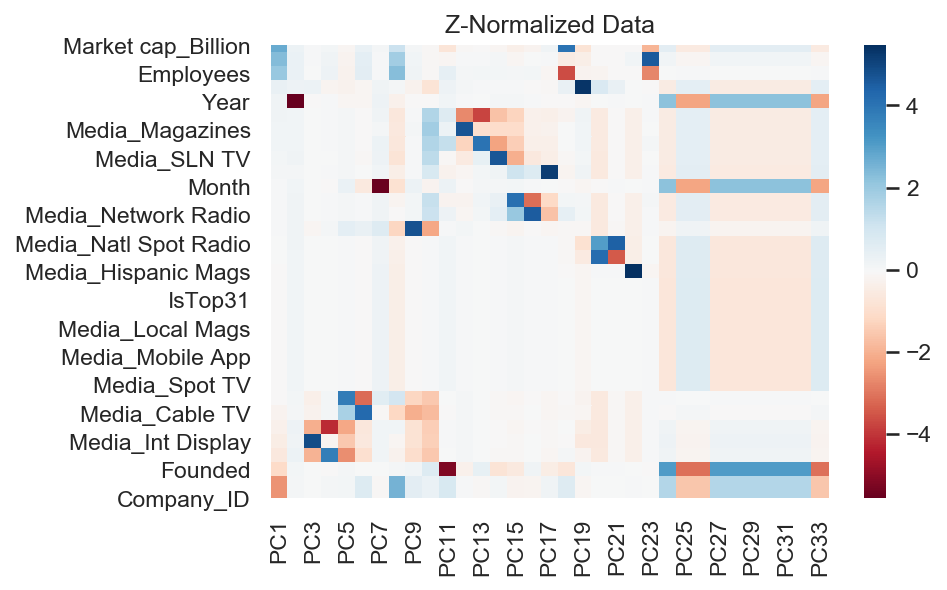

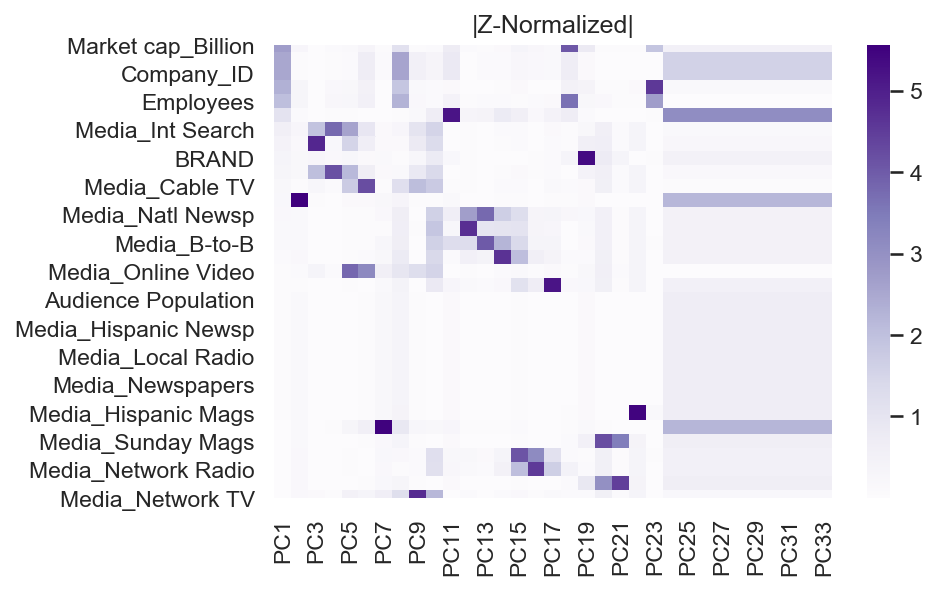

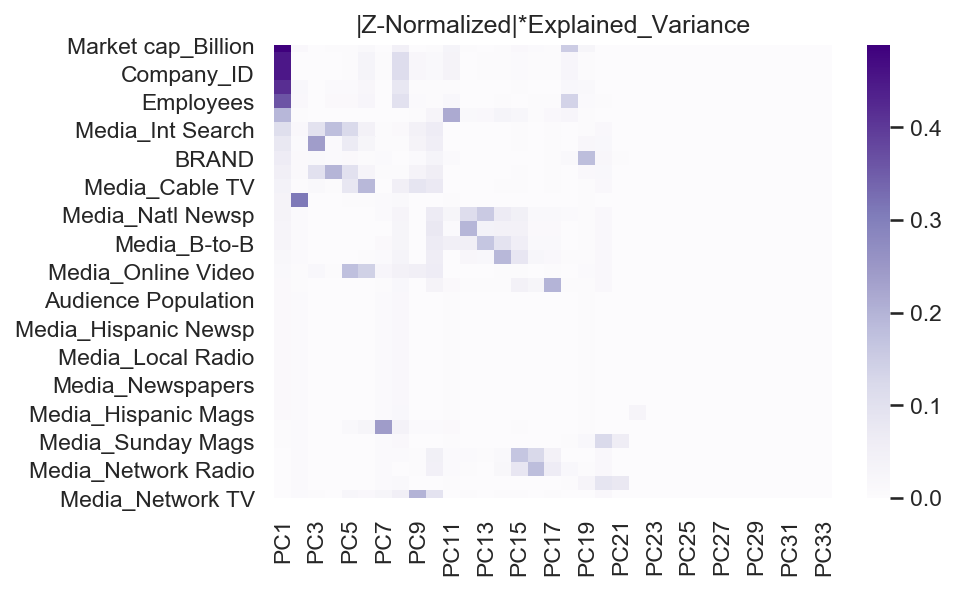

        score_               feature_
rank                                 
1     0.853714     Market cap_Billion
2     0.748783             Company_ID
3     0.748783                   Rank
4     0.737673       Media_Int Search
5     0.737036              Employees
6     0.661593       Media_Mobile Web
7     0.632025       Media_Natl Newsp
8     0.627287           Media_B-to-B
9     0.623707        Revenue_Billion
10    0.606729         Media_Cable TV
11    0.605702      Media_Int Display
12    0.603081                Founded
13    0.601197     Media_Online Video
14    0.542011        Media_Magazines
15    0.528427           Media_SLN TV
16    0.493800    Media_Network Radio
17    0.491081      Media_Syndication
18    0.487461       Media_Network TV
19    0.420448          Media_Outdoor
20    0.420308                  BRAND
21    0.412714                   Year
22    0.397847                  Month
23    0.266437      Media_Sunday Mags
24    0.255563  Media_Natl Spot Radio
25    0.1058

In [134]:
data = pca_dataset
outputs = pca_full_report(X=scaled, features_=scaled_features.columns)

Put the function code into a separate py and import

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
df = comp_df_new[comp_df_new['DMA_Code']==0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3578 entries, 0 to 95731
Data columns (total 43 columns):
Company                  3578 non-null object
DMA_Code                 3578 non-null category
MEDIA                    3578 non-null object
Division_Name            3578 non-null object
Year                     3578 non-null int64
Month                    3578 non-null int64
Audience Population      3578 non-null int64
BRAND                    3578 non-null int64
Employees                3578 non-null int64
Founded                  3578 non-null int64
IsTop31                  3578 non-null category
Market cap_Billion       3349 non-null float64
Rank                     3578 non-null int64
Revenue_Billion          3578 non-null float64
Spend_K                  3578 non-null float64
Company_ID               3578 non-null category
Media_B-to-B             3578 non-null uint8
Media_Cable TV           3578 non-null uint8
Media_Hispanic Mags      3578 non-null uint8
Media_Hispanic News

In [93]:
nat_comp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3578 entries, 0 to 95731
Data columns (total 34 columns):
Year                     3578 non-null int64
Month                    3578 non-null int64
Audience Population      3578 non-null int64
BRAND                    3578 non-null int64
Employees                3578 non-null int64
Founded                  3578 non-null int64
IsTop31                  3578 non-null category
Market cap_Billion       3349 non-null float64
Rank                     3578 non-null int64
Revenue_Billion          3578 non-null float64
Spend_K                  3578 non-null float64
Company_ID               3578 non-null category
Media_B-to-B             3578 non-null uint8
Media_Cable TV           3578 non-null uint8
Media_Hispanic Mags      3578 non-null uint8
Media_Hispanic Newsp     3578 non-null uint8
Media_Int Display        3578 non-null uint8
Media_Int Search         3578 non-null uint8
Media_Local Mags         3578 non-null uint8
Media_Local Radio        

### Future Work

Use future n months advertising spend as features and create a RandomForest Regressor model to predict future advertising spend